In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('use: ',device)

use:  cuda


In [3]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])
 
dataset = torchvision.datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform) 

loader = torch.utils.data.DataLoader(dataset,
                                     batch_size = 256,
                                     num_workers = 0,
                                     shuffle = False)

Files already downloaded and verified


In [5]:
mean = 0.0
for img,a in loader:
    batch_samples = img.size(0)
    img = img.view(batch_samples, img.size(1),-1)
    mean += img.mean(2).sum(0)
mean = mean/len(loader.dataset)
mean

tensor([0.4914, 0.4822, 0.4465])

In [6]:
batch_size = 256

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size, shuffle=True, drop_last=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset,batch_size=batch_size, shuffle=False, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def init_weights(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

In [8]:
def cfg(depth):
    depth_list = [18,34,50,101,152]
    assert (depth in depth_lst), "Error : Resnet depth should be either 18, 34, 50, 101, 152"
    cf_dict = {
        '18': (BasicBlock, [2,2,2,2]),
        '34': (BasicBlock, [3,4,6,3]),
        '50': (Bottleneck, [3,4,6,3]),
        '101':(Bottleneck, [3,4,23,3]),
        '152':(Bottleneck, [3,8,36,3]),
    }
    return cf_dict[str(depth)]

In [9]:
class BasicBlock(nn.Module): # Resnet 18,34
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes: # 첫 번째 shortcut 위한 장치..?
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class Bottleneck(nn.Module): # Resnet 50,101,152
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride)) # num_block 개수만큼 블록 쌓기
            self.in_planes = planes * block.expansion # ResNet34 에서는 num_block이 바뀔때만 바뀔듯
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])    

In [10]:
model = ResNet34().to(device)
model.apply(init_weights)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [11]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [12]:
total_batch = len(trainloader)
print(f'total_batch : {total_batch}')

total_batch : 195


In [13]:
from tqdm import tqdm

training_epoch = 100
train_accuracy_list = []
test_accuracy_list = []
for epoch in tqdm(range(training_epoch), disable=False, mininterval=0.01):
    train_accuracy = 0
    test_accuracy = 0
    model.train()
    for X,y in trainloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_accuracy += (output.argmax(1)==y).float().mean()
    train_accuracy_list.append(train_accuracy/total_batch)
    scheduler.step(loss)
    model.eval()
    for X,y in testloader:
        with torch.no_grad():
            X = X.to(device)
            y = y.to(device)
            result = model(X)
            test_accuracy += (result.argmax(1)==y).float().mean()
    test_accuracy_list.append(test_accuracy/len(testloader))

100%|██████████| 100/100 [2:01:09<00:00, 72.70s/it] 


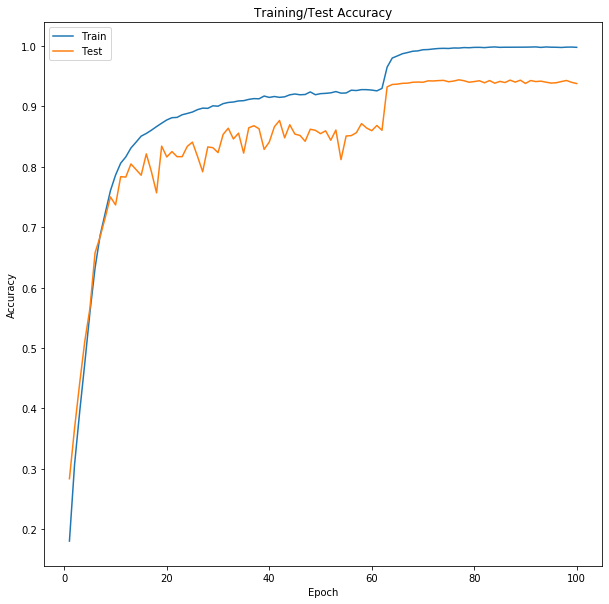

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Training/Test Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.plot(range(1, len(train_accuracy_list)+1), train_accuracy_list)
ax.plot(range(1, len(test_accuracy_list)+1), test_accuracy_list)
ax.legend(['Train', 'Test'])
plt.show()

In [15]:
torch.save({
            'epoch': training_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'train_accuracy': train_accuracy_list,
            'test_accuracy' : test_accuracy_list
            }, './save/Resnet34_checkpoint.pt')

In [16]:
ck = torch.load('./save/Resnet34_checkpoint.pt')

In [18]:
ck['test_accuracy'][99]

tensor(0.9373, device='cuda:0')